Tianyou Xiao (tx43), Ziyu Song (zs363)

CS 5785 HW 1 House Prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import skew


%matplotlib inline

In [2]:
url_train = 'https://raw.githubusercontent.com/dzuhyoosg/Applied-Machine-Learning/master/homework1/house-prices/train.csv'
url_test = 'https://raw.githubusercontent.com/dzuhyoosg/Applied-Machine-Learning/master/homework1/house-prices/test.csv'

train = pd.read_csv(url_train)
test = pd.read_csv(url_test)

# this part of code is only used for local run
# train = pd.read_csv('./house-prices/train.csv', header=0)
# test = pd.read_csv('./house-prices/test.csv', header=0)

In [3]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Data Exploration

In [6]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <a list of 10 Patch objects>)

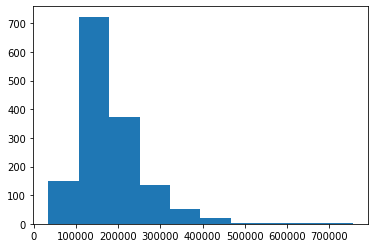

In [7]:
# check the skewness of the target variable
plt.hist(train['SalePrice'])

Most of the density lies between 100k and 250k. It appears to be a lot of outliers.

In [8]:
# check if there is any missing data (null values)
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Row Count', 'Percentage'])
missing_data.head(20)

,Row Count,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


2 (b) Building least squares model

In [9]:
# feature engineering

# process the features in both train and test dataset for convenience
data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

# drop features where most values are missing
data = data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)

# fix the skewness in the data by taking log of them
numeric_features = data.select_dtypes(include=[np.number])

skewed_features = numeric_features.apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

data[skewed_features] = np.log1p(data[skewed_features])

# create dummy vars for categorical features
data = pd.get_dummies(data) 

# fill the remaining missing values with mean value of corresponding features
data = data.fillna(data.mean())

In [10]:
# remove the skewness of target var, and split the dataset again
train["SalePrice"] = np.log1p(train["SalePrice"])

X_train = data[:train.shape[0]]
X_test = data[train.shape[0]:]
y = train.SalePrice

outliers = [30, 88, 462, 631, 1322]
X_train = X_train.drop(X_train.index[outliers])
y = y.drop(y.index[outliers])

In [11]:
# fit and predict
model = LinearRegression().fit(X_train, y)
predictions = model.predict(X_train)

print("R^2 is: ", model.score(X_train, y))
print('RMSE is: ', mean_squared_error(y, predictions))

R^2 is:  0.9490056329917647
RMSE is:  0.008035230899374924


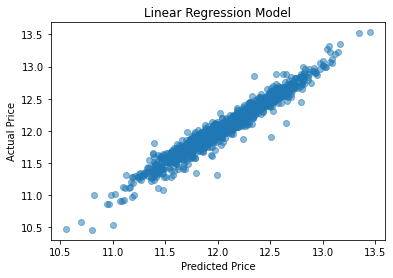

In [12]:
# to visualize how our model performs
plt.scatter(predictions, y, alpha=.5)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

2 (c) Building regularized least squares model

L1 Regulation: Lasso Regression 

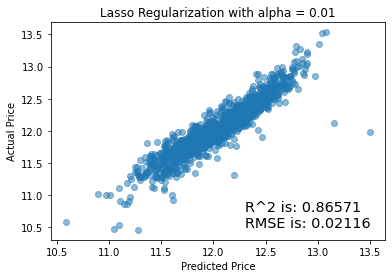

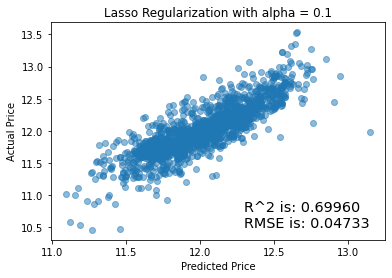

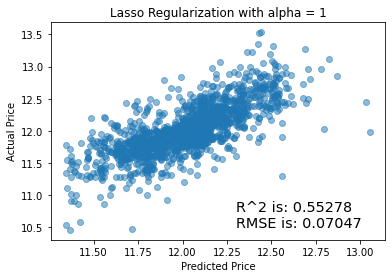

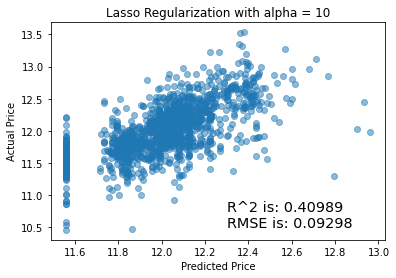

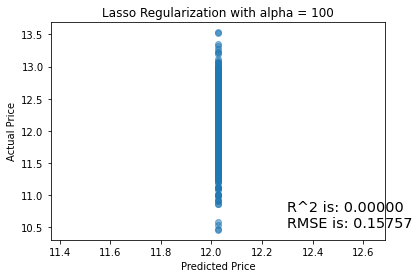

In [13]:
# try out different regularization coefficient
for i in range (-2, 3):
    alpha = 10**i
    rm = Lasso(alpha=alpha)
    lasso_model = rm.fit(X_train, y)
    pred_lasso = lasso_model.predict(X_train)

    plt.scatter(pred_lasso, y, alpha=.5)
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Lasso Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {:.5f}\nRMSE is: {:.5f}'.format(
        lasso_model.score(X_train, y), 
        mean_squared_error(y, pred_lasso))
    plt.annotate(s=overlay,xy=(12.3,10.5),size='x-large')
    plt.savefig('l1_{}'.format(i+3))
    plt.show()

L2 Regularization: Ridge Regression

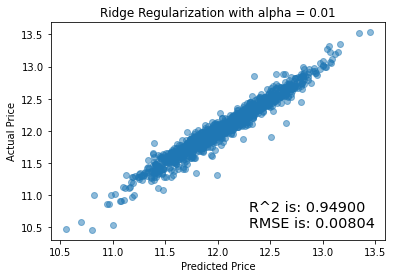

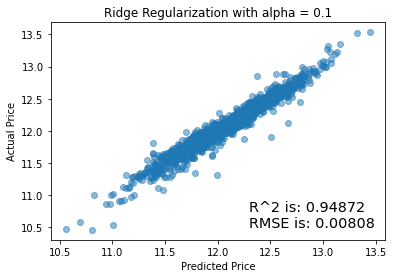

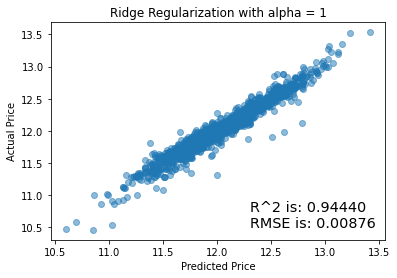

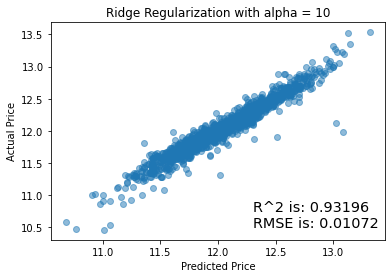

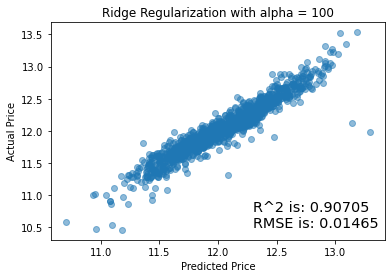

In [14]:
# try out different regularization coefficient
for i in range (-2, 3):
    alpha = 10**i
    rm = Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y)
    pred_ridge = ridge_model.predict(X_train)

    plt.scatter(pred_ridge, y, alpha=.5)
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {:.5f}\nRMSE is: {:.5f}'.format(
        ridge_model.score(X_train, y), 
        mean_squared_error(y, pred_ridge))
    plt.annotate(s=overlay,xy=(12.3,10.5),size='x-large')
    plt.savefig('l2_{}'.format(i+3))
    plt.show()

Kaggle Submission

In [15]:
submission = pd.DataFrame()
submission['Id'] = test.Id

In [16]:
# The normal least square regression model works best for us, so we submit our results using it
final_predictions = np.exp(model.predict(X_test))

In [17]:
print("Original predictions are: \n", predictions[:5], "\n")
print("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [12.23651652 12.19237957 12.28645749 12.00984975 12.6001559 ] 

Final predictions are: 
 [122728.89475436 156541.29966858 191394.84213816 200766.26326924
 200351.87159175]


In [18]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,122728.894754
1,1462,156541.299669
2,1463,191394.842138
3,1464,200766.263269
4,1465,200351.871592


In [19]:
submission.to_csv('kaggle_submission.csv', index=False)